# Process the Load Data for the Nuclear Heat Wave Grid Stress Events


In [1]:
# Start by importing the packages we need:
import os
import glob
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the data input and image output directory:
data_dir =  '/Users/burl878/Documents/Code/code_repos/nuclear_heat_wave_loads/data/'
plot_dir =  '/Users/burl878/Documents/Code/code_repos/nuclear_heat_wave_loads/plots/'


## Suppress Future Warnings


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Create a Function to Process the 2030 GridView Data Used in Scaling


In [18]:
def process_gridview_data(data_dir: str):
    
    # Read in the raw data .csv file:
    gv_df = pd.read_csv((data_dir + 'WECC_2030_LOAD.csv'))
    
    # Subset to just the annual total demand by BA:
    gv_df = gv_df[-3:-2]
       
    # Strip the unecessary bits from the column names:
    gv_df.columns = gv_df.columns.str.replace("_CEC", "")
    gv_df.columns = gv_df.columns.str.replace("_2030.dat", "")
    gv_df.columns = gv_df.columns.str.replace("Load_", "")
       
    # Delete the index column:
    del gv_df["Index"], gv_df["Unnamed: 44"]
    
    # Convert the values to floats:
    gv_df = gv_df.astype(float64)
    
    # Compute the total loads for CISO, IPCO, NEVP, and PACE:
    gv_df['CISO'] = (gv_df['CIPB'] + gv_df['CIPV'] + gv_df['CISC'] + gv_df['CISD'] + gv_df['VEA']).round(2)
    gv_df['IPCO'] = (gv_df['IPFE'] + gv_df['IPMV'] + gv_df['IPTV']).round(2)
    gv_df['PACE'] = (gv_df['PAID'] + gv_df['PAUT'] + gv_df['PAWY']).round(2)
    gv_df['NEVP_Sum'] = (gv_df['NEVP'] + gv_df['SPPC']).round(2)
           
    # Rename a few columns for consistency:
    gv_df.rename(columns={'CIPB': 'CISO_CIPB', 'CIPV': 'CISO_CIPV', 'CISC': 'CISO_CISC', 'CISD': 'CISO_CISD', 'VEA': 'CISO_VEA',
                          'IPFE': 'IPCO_IPFE', 'IPMV': 'IPCO_IPMV', 'IPTV': 'IPCO_IPTV',
                          'NEVP': 'NEVP_NEVP', 'SPPC': 'NEVP_SPPC',
                          'PAID': 'PACE_PAID', 'PAUT': 'PACE_PAUT', 'PAWY': 'PACE_PAWY'}, inplace=True) 
    gv_df.rename(columns={'NEVP_Sum': 'NEVP'}, inplace=True) 
    
    # Squeeze the dataframe:
    gv_df = gv_df.squeeze().to_frame()
        
    # Rename the columns:
    gv_df.reset_index(inplace=True)
    gv_df = gv_df.rename(columns = {'index':'BA'})
    gv_df.rename(columns={gv_df.columns[1]: "Total_Load_MWh" }, inplace = True)
       
    # Sort the dataframe alphabetically by BA name:
    gv_df = gv_df.sort_values('BA')
       
    # Return the output dataframe:
    return gv_df


In [20]:
# Read in the processed GridView file and rename a column for consistency:
gv_df = process_gridview_data(data_dir = data_dir)
gv_df.rename(columns={'Total_Load_MWh': 'GV_Total_Load_MWh'}, inplace=True) 

gv_df


,BA,GV_Total_Load_MWh
0,AESO,96334990.0
1,AVA,13700840.0
2,AZPS,43196860.0
3,BANC,18552430.0
4,BCHA,65680680.0
5,BPAT,69348320.0
6,CFE,22031280.0
7,CHPD,1971675.0
43,CISO,247877970.0
8,CISO_CIPB,48892610.0


## Create a Function to Aggregate the Raw TELL MLP Output into a Single Dataframe:


In [21]:
def aggregate_mlp_output_files(data_dir: str, year_to_process: str):
    
    # Create a list of all of the MLP output files in the "mlp_input_dir" and aggregate the files in that list:
    list_of_files = sorted(glob.glob(os.path.join(data_dir, 'TELL_Data', year_to_process, '*_mlp_output.csv')))

    # Loop over the list of MLP output files:
    for file in range(len(list_of_files)):

        # Read in the .csv file and replace missing values with nan:
        mlp_data = pd.read_csv(list_of_files[file]).replace(-9999, np.nan)

        # Rename the "Load" variable:
        mlp_data.rename(columns={'Load': 'Hourly_Load_MWh'}, inplace=True)

        # Replacing missing or negative loads with NaN:
        mlp_data.loc[~(mlp_data['Hourly_Load_MWh'] > 0), 'Hourly_Load_MWh'] = np.nan

        # Aggregate the output into a new dataframe:
        if file == 0:
            tell_df = mlp_data
        else:
            tell_df = pd.concat([tell_df, mlp_data])
    
    # Return the output dataframe:
    return tell_df


## Create a Function to Scale the TELL Output Based on the GridView 2030 Values:


In [22]:
def scale_tell_loads(data_dir: str, year_to_process: str):
    
    # Aggregate the TELL MLP files:
    tell_df = aggregate_mlp_output_files(data_dir = data_dir,
                                         year_to_process = year_to_process)
    
    # Read in the processed GridView file and rename a column for consistency:
    gv_df = process_gridview_data(data_dir = data_dir)
    gv_df.rename(columns={'Total_Load_MWh': 'GV_Total_Load_MWh'}, inplace=True) 
    
    # Merge the tell_df and gv_df dataframes based on common BA names:
    merged_df = tell_df.merge(gv_df, on=['BA'])
    
    # Sum the hourly TELL loads by BA into annual total loads:
    merged_df['TELL_Total_Load_MWh'] = merged_df.groupby('BA')['Hourly_Load_MWh'].transform('sum')
    
    # Compute the scaling factors that force the annual total loads to agree:
    merged_df['Scaling_Factor'] = merged_df['GV_Total_Load_MWh'] / merged_df['TELL_Total_Load_MWh']
    
    # Compute the scaled hourly loads:
    merged_df['Hourly_Load_MWh_Scaled'] = merged_df['Hourly_Load_MWh'] * merged_df['Scaling_Factor']
    
    # Compute the hours since the start of the year:
    merged_df['Hour'] = ((pd.to_datetime(merged_df['Time_UTC']) - datetime.datetime(int(year_to_process), 1, 1, 0, 0, 0)) / np.timedelta64(1, 'h') + 1).astype(int)
    
    # Only keep the columns that are needed:
    scaled_tell_df = merged_df[['Hour', 'BA', 'Hourly_Load_MWh_Scaled']].copy()
    
    # Drop the rows with missing values (i.e., there is not a corresponding GridView load):
    scaled_tell_df = scaled_tell_df.dropna(how = 'any')
    
    # Rename the load variable and round it to 5 decimals:
    scaled_tell_df.rename(columns={'Hourly_Load_MWh_Scaled': 'Load_MWh'}, inplace=True)
    scaled_tell_df['Load_MWh'] = scaled_tell_df['Load_MWh'].round(5)
    
    # Return the output dataframe:
    return scaled_tell_df


## Create a Function to Format the Output for Ingest to GridView:


In [28]:
def format_scaled_tell_loads(data_dir: str, year_to_process: str):
    
    # Process the GridView file:
    gv_df = process_gridview_data(data_dir = data_dir)
    
    # Compute the load fractions for the subregions:
    CIPB_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CIPB')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CIPV_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CIPV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CISC_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CISC')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    CISD_LF = (gv_df.loc[(gv_df['BA'] == 'CISO_CISD')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    VEA_LF  = (gv_df.loc[(gv_df['BA'] == 'CISO_VEA' )]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'CISO')]['Total_Load_MWh'].values[0])
    IPFE_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPFE')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    IPMV_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPMV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    IPTV_LF = (gv_df.loc[(gv_df['BA'] == 'IPCO_IPTV')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'IPCO')]['Total_Load_MWh'].values[0])
    NEVP_LF = (gv_df.loc[(gv_df['BA'] == 'NEVP_NEVP')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'NEVP')]['Total_Load_MWh'].values[0])
    SPPC_LF = (gv_df.loc[(gv_df['BA'] == 'NEVP_SPPC')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'NEVP')]['Total_Load_MWh'].values[0])
    PAID_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAID')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    PAUT_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAUT')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    PAWY_LF = (gv_df.loc[(gv_df['BA'] == 'PACE_PAWY')]['Total_Load_MWh'].values[0]) / (gv_df.loc[(gv_df['BA'] == 'PACE')]['Total_Load_MWh'].values[0])
    
    # Aggregate the TELL MLP files:
    scaled_tell_df = scale_tell_loads(data_dir = data_dir, 
                                      year_to_process = year_to_process)
   
    # Reshape the dataframe and drop the indexes:
    load_df = scaled_tell_df.pivot(index = 'Hour', columns = 'BA', values = 'Load_MWh')
    load_df = load_df.reset_index(drop=False)
    
    # Add back in the text to the column headers:
    load_df = load_df.add_suffix('_2030.dat')
    load_df = load_df.add_prefix('Load_')
    
    # Rename the time variable:
    load_df.rename(columns={'Load_Hour_2030.dat': 'Index'}, inplace=True)
    
    # Compute the loads for the subregions:
    load_df['Load_CIPB_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CIPB_LF
    load_df['Load_CIPV_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CIPV_LF
    load_df['Load_CISC_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CISC_LF
    load_df['Load_CISD_2030_CEC.dat'] = load_df['Load_CISO_2030.dat'] * CISD_LF
    load_df['Load_VEA_2030.dat'] = load_df['Load_CISO_2030.dat'] * VEA_LF
    load_df['Load_IPFE_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPFE_LF
    load_df['Load_IPMV_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPMV_LF
    load_df['Load_IPTV_2030.dat'] = load_df['Load_IPCO_2030.dat'] * IPTV_LF
    load_df['Load_NEVP_Temp_2030.dat'] = load_df['Load_NEVP_2030.dat'] * NEVP_LF
    load_df['Load_SPPC_2030.dat'] = load_df['Load_NEVP_2030.dat'] * SPPC_LF
    load_df['Load_PAID_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAID_LF
    load_df['Load_PAUT_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAUT_LF
    load_df['Load_PAWY_2030.dat'] = load_df['Load_PACE_2030.dat'] * PAWY_LF
    
    # Drop the un-needed columns for BAs with subregions:
    del load_df['Load_NEVP_2030.dat'], load_df['Load_CISO_2030.dat'], load_df['Load_IPCO_2030.dat'], load_df['Load_PACE_2030.dat']

    # Clean up the NEVP naming:
    load_df.rename(columns={'Load_NEVP_Temp_2030.dat': 'Load_NEVP_2030.dat'}, inplace=True)
    
    # Read in the raw data GridView .csv file:
    raw_gv_df = pd.read_csv((data_dir + 'WECC_2030_LOAD.csv'))
    
    # Delete the index column:
    del raw_gv_df["Index"] 
    
    # Subset to just the rows we need:
    raw_gv_df = raw_gv_df[1:8761]
    
    # Convert the values to floats:
    raw_gv_df = raw_gv_df.astype('float64')
    
    # Shift the index by -1:
    raw_gv_df = raw_gv_df.reset_index()
    
    # Merge in the GridView columns that aren't modeled by TELL:
    load_df = pd.concat([load_df,raw_gv_df['Load_AESO_2030.dat']], axis=1)
    load_df = pd.concat([load_df,raw_gv_df['Load_BCHA_2030.dat']], axis=1)
    load_df = pd.concat([load_df,raw_gv_df['Load_CFE_2030.dat']], axis=1)
    load_df = pd.concat([load_df,raw_gv_df['Load_TH_Malin_2030.dat']], axis=1)
    load_df = pd.concat([load_df,raw_gv_df['Load_TH_Mead_2030.dat']], axis=1)
    load_df = pd.concat([load_df,raw_gv_df['Load_TH_PV_2030.dat']], axis=1)
    
    # Create a target dataframe with the spare hours:
    target_df = pd.DataFrame({"Index": np.arange(1,8791,1)})
    
    # Merge load dataframe with the target dataframe:
    merged_df = target_df.merge(load_df, on=['Index'], how='left')
    
    # Compute the summary statistics:
    stats_df = merged_df.apply(['mean','sum','max','min'])
    
    # Fix the summary statistic labels:
    stats_df.iloc[0, 0] = 'AVG'
    stats_df.iloc[1, 0] = 'SUM'
    stats_df.iloc[2, 0] = 'MAX'
    stats_df.iloc[3, 0] = 'MIN'
      
    # Sort the data by column name and make the Index column appear first:
    merged_df.rename(columns={'Index': 'AA'}, inplace=True)
    merged_df = merged_df.sort_index(axis = 1)
    merged_df.rename(columns={'AA': 'Index'}, inplace=True)
    
    # Add in a blank row and fill it with the year placeholder:
    merged_df.loc[-0.5] = 0
    merged_df = merged_df.sort_index().reset_index(drop=True)
    merged_df.iloc[0, :] = '2030'
    merged_df.at[0, 'Index'] = 'Year'
        
    # Merge the hourly load data and statistics dataframes together:
    output_df = pd.concat([merged_df, stats_df], axis=0)
    
    # Replace NaNs with blank values:
    output_df.replace(np.nan, "", regex=True)
    
    # Set the output filename:
    if year_to_process == '2015':
       output_filename = 'TELL_Loads_2030_Based_on_2015_Weather.csv'
    if year_to_process == '2018':
       output_filename = 'TELL_Loads_2030_Based_on_2018_Weather.csv'
    if year_to_process == '2055':
       output_filename = 'TELL_Loads_2030_Based_on_2015_Weather_With_Climate_Change.csv'
    if year_to_process == '2058':
       output_filename = 'TELL_Loads_2030_Based_on_2018_Weather_With_Climate_Change.csv'
    
    # Write out the dataframe to a .csv file:
    output_df.to_csv((os.path.join(data_dir, output_filename)), sep=',', index=False)
    
    # Return the output dataframe:
    return output_df


## Call the Necessary Functions to Process the Data:


In [30]:
output_df = format_scaled_tell_loads(data_dir = data_dir,
                                     year_to_process = '2058')

output_df


,Index,Load_AESO_2030.dat,Load_AVA_2030.dat,Load_AZPS_2030.dat,Load_BANC_2030.dat,Load_BCHA_2030.dat,Load_BPAT_2030.dat,Load_CFE_2030.dat,Load_CHPD_2030.dat,Load_CIPB_2030_CEC.dat,...,Load_TEPC_2030.dat,Load_TH_Malin_2030.dat,Load_TH_Mead_2030.dat,Load_TH_PV_2030.dat,Load_TIDC_2030.dat,Load_TPWR_2030.dat,Load_VEA_2030.dat,Load_WACM_2030.dat,Load_WALC_2030.dat,Load_WAUW_2030.dat
0,Year,2030,2030,2030,2030,2030,2030,2030,2030,2030,...,2030,2030,2030,2030,2030,2030,2030,2030,2030,2030
1,1,10961.0,1855.42866,3499.07666,1852.90065,8020.0,8549.39306,1775.0,334.84827,4769.321035,...,2122.3013,0.0,0.0,0.0,223.79283,695.48727,73.266478,3608.86928,873.76981,136.69212
2,2,10826.0,1920.4559,3790.31341,1978.66392,7440.0,9054.1644,1707.0,341.05731,5013.626145,...,2114.66879,0.0,0.0,0.0,255.11039,732.00902,77.019502,3649.12892,897.7324,136.43041
3,3,10744.0,1977.53983,3921.62148,2005.747,7173.0,9346.09489,1665.0,335.90945,5170.056636,...,2069.61747,0.0,0.0,0.0,257.7363,748.87075,79.422592,3690.20505,879.55459,136.21903
4,4,10738.0,2030.37662,4025.3907,2083.73815,7027.0,9604.89564,1639.0,333.34681,5327.345738,...,2040.30668,0.0,0.0,0.0,262.24513,762.62556,81.838873,3646.41773,873.10075,134.8199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,AVG,10997.146918,1564.022831,4931.148402,2117.857306,7497.783904,7916.474886,2514.986416,225.077055,5581.348174,...,2085.947489,0.0,0.0,0.0,326.678539,558.158676,85.740868,3211.152968,1102.297945,96.02637
sum,SUM,96335007.0,13700840.00004,43196859.99994,18552429.9994,65680587.0,69348319.99982,22031281.0,1971675.00026,48892609.999998,...,18272900.00016,0.0,0.0,0.0,2861704.00023,4889469.99973,751090.0,28129699.99991,9656130.00026,841190.99979
max,MAX,13241.0,2572.98964,10758.28217,4654.11663,12204.0,12216.75958,4301.0,453.05723,10494.917239,...,4325.80471,0.0,0.0,0.0,672.99677,879.36142,161.223289,4743.21544,1772.54182,175.1632


## Create a Function to Calculate Changes in Minimum and Maximum Loads by BA


In [48]:
def create_delta_plots(data_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Loop over the years
    for year in [2015, 2018, 2030]:
        
        # Set the output filename:
        if str(year) == '2030':
           input_filename = 'WECC_2030_LOAD.csv'
        if str(year) == '2015':
           input_filename = 'TELL_Loads_2030_Based_on_2015_Weather_With_Climate_Change.csv'
        if str(year) == '2018':
           input_filename = 'TELL_Loads_2030_Based_on_2018_Weather_With_Climate_Change.csv' 
    
        # Read in the raw TELL data .csv file:
        tell_df = pd.read_csv((data_dir + input_filename))
        
        # Strip the unecessary bits from the column names:
        tell_df.columns = tell_df.columns.str.replace("_CEC", "")
        tell_df.columns = tell_df.columns.str.replace("_2030.dat", "")
        tell_df.columns = tell_df.columns.str.replace("Load_", "")
    
        # Subset to just the annual max demand by BA:
        max_df = pd.DataFrame(tell_df.filter(items=[8793], axis=0).drop('Index', axis=1).squeeze()).reset_index()
        max_df.rename(columns={'index': 'BA'}, inplace=True)
        if year == 2015:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2015'}, inplace=True)
        if year == 2018:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2018'}, inplace=True)
        if year == 2030:
           max_df.rename(columns={max_df.columns[1]: 'Max_Load_2030'}, inplace=True)
    
        # Subset to just the annual min demand by BA:
        min_df = pd.DataFrame(tell_df.filter(items=[8794], axis=0).drop('Index', axis=1).squeeze()).reset_index()
        min_df.rename(columns={'index': 'BA'}, inplace=True)
        if year == 2015:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2015'}, inplace=True)
        if year == 2018:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2018'}, inplace=True)
        if year == 2030:
           min_df.rename(columns={min_df.columns[1]: 'Min_Load_2030'}, inplace=True)
    
        if year == 2015:
           # Assign the output_df as the temp_df:  
           output_df = max_df.merge(min_df, on=['BA'])
        else:
           # Merge the output_df and temp_df dataframes based on common BA names:
           output_df = output_df.merge(max_df, on=['BA'])
           output_df = output_df.merge(min_df, on=['BA'])
        
        # Clean up and move to the next year:
        del tell_df, max_df, min_df, input_filename
    
    # Convert the values to numeric:
    output_df[['Min_Load_2030', 'Max_Load_2030']] = output_df[['Min_Load_2030', 'Max_Load_2030']].apply(pd.to_numeric)
    
    # Compute the min and max loads:
    max_min_load = 1.05*output_df[['Min_Load_2015', 'Min_Load_2018', 'Min_Load_2030']].max().max().max()
    min_max_load = 0.95*output_df[['Max_Load_2015', 'Max_Load_2018', 'Max_Load_2030']].min().min().min()
    max_max_load = 1.05*output_df[['Max_Load_2015', 'Max_Load_2018', 'Max_Load_2030']].max().max().max()
    
    # Make the plot:
    plt.figure(figsize=(20, 15))
    plt.rcParams['font.size'] = 15
    
    plt.subplot(221)
    plt.plot([0, max_min_load], [0, max_min_load], color='k', linestyle='-', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.8*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.9*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.1*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.2*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Min_Load_2030'], output_df['Min_Load_2015'], s=50, c='blue')
    plt.xlim([0, max_min_load]); plt.ylim([0, max_min_load]);
    plt.xlabel('Base Year Min Load [MWh]')
    plt.ylabel('2015 Weather Year Min Load [MWh]')
    plt.title('BA Annual Minimum Load: 2015 Comparison')
    
    plt.subplot(222)
    plt.plot([0, max_min_load], [0, max_min_load], color='k', linestyle='-', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.8*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.plot([0, max_min_load], [0, 0.9*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.1*max_min_load], color='k', linestyle='--', linewidth=1)
    plt.plot([0, max_min_load], [0, 1.2*max_min_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Min_Load_2030'], output_df['Min_Load_2018'], s=50, c='red')
    plt.xlim([0, max_min_load]); plt.ylim([0, max_min_load]);
    plt.xlabel('Base Year Min Load [MWh]')
    plt.ylabel('2018 Weather Year Min Load [MWh]')
    plt.title('BA Annual Minimum Load: 2018 Comparison')
    
    plt.subplot(223)
    plt.plot([min_max_load, max_max_load], [min_max_load, max_max_load], color='k', linestyle='-', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.8*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.9*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.1*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.2*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Max_Load_2030'], output_df['Max_Load_2015'], s=50, c='blue')
    plt.xlim([min_max_load, max_max_load]); plt.ylim([min_max_load, max_max_load]);
    plt.xlabel('Base Year Max Load [MWh]')
    plt.ylabel('2015 Weather Year Max Load [MWh]')
    plt.title('BA Annual Maximum Load: 2015 Comparison')
    
    plt.subplot(224)
    plt.plot([min_max_load, max_max_load], [min_max_load, max_max_load], color='k', linestyle='-', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.8*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 0.9*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.1*max_max_load], color='k', linestyle='--', linewidth=1)
    plt.plot([min_max_load, max_max_load], [min_max_load, 1.2*max_max_load], color='k', linestyle=':', linewidth=1)
    plt.scatter(output_df['Max_Load_2030'], output_df['Max_Load_2018'], s=50, c='red')
    plt.xlim([min_max_load, max_max_load]); plt.ylim([min_max_load, max_max_load]);
    plt.xlabel('Base Year Max Load [MWh]')
    plt.ylabel('2018 Weather Year Max Load [MWh]')
    plt.title('BA Annual Maximum Load: 2018 Comparison')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, 'Delta_Plots.png'), dpi=image_resolution, bbox_inches='tight', facecolor='white')

    return output_df
    

,BA,Max_Load_2015,Min_Load_2015,Max_Load_2018,Min_Load_2018,Max_Load_2030,Min_Load_2030
0,AESO,13241.000000,9039.000000,13241.000000,9039.000000,13241.000,9039.000
1,AVA,2538.040200,943.169570,2572.989640,914.525220,2360.000,945.000
2,AZPS,10500.695630,3004.374480,10758.282170,2949.707150,8961.000,3200.000
3,BANC,4719.569580,1342.502560,4654.116630,1364.112000,4832.000,1073.000
4,BCHA,12204.000000,3450.000000,12204.000000,3450.000000,12204.000,3450.000
5,BPAT,11366.846660,5644.747180,12216.759580,5678.588640,12901.000,4797.000
6,CFE,4301.000000,1383.000000,4301.000000,1383.000000,4301.000,1383.000
7,CHPD,416.176480,114.785940,453.057230,114.596430,497.000,81.000
8,CIPB,10309.814314,3808.385320,10494.917239,3871.949411,8752.994,3923.087
9,CIPV,13443.701926,4966.025139,13685.070828,5048.910889,14144.200,2477.997


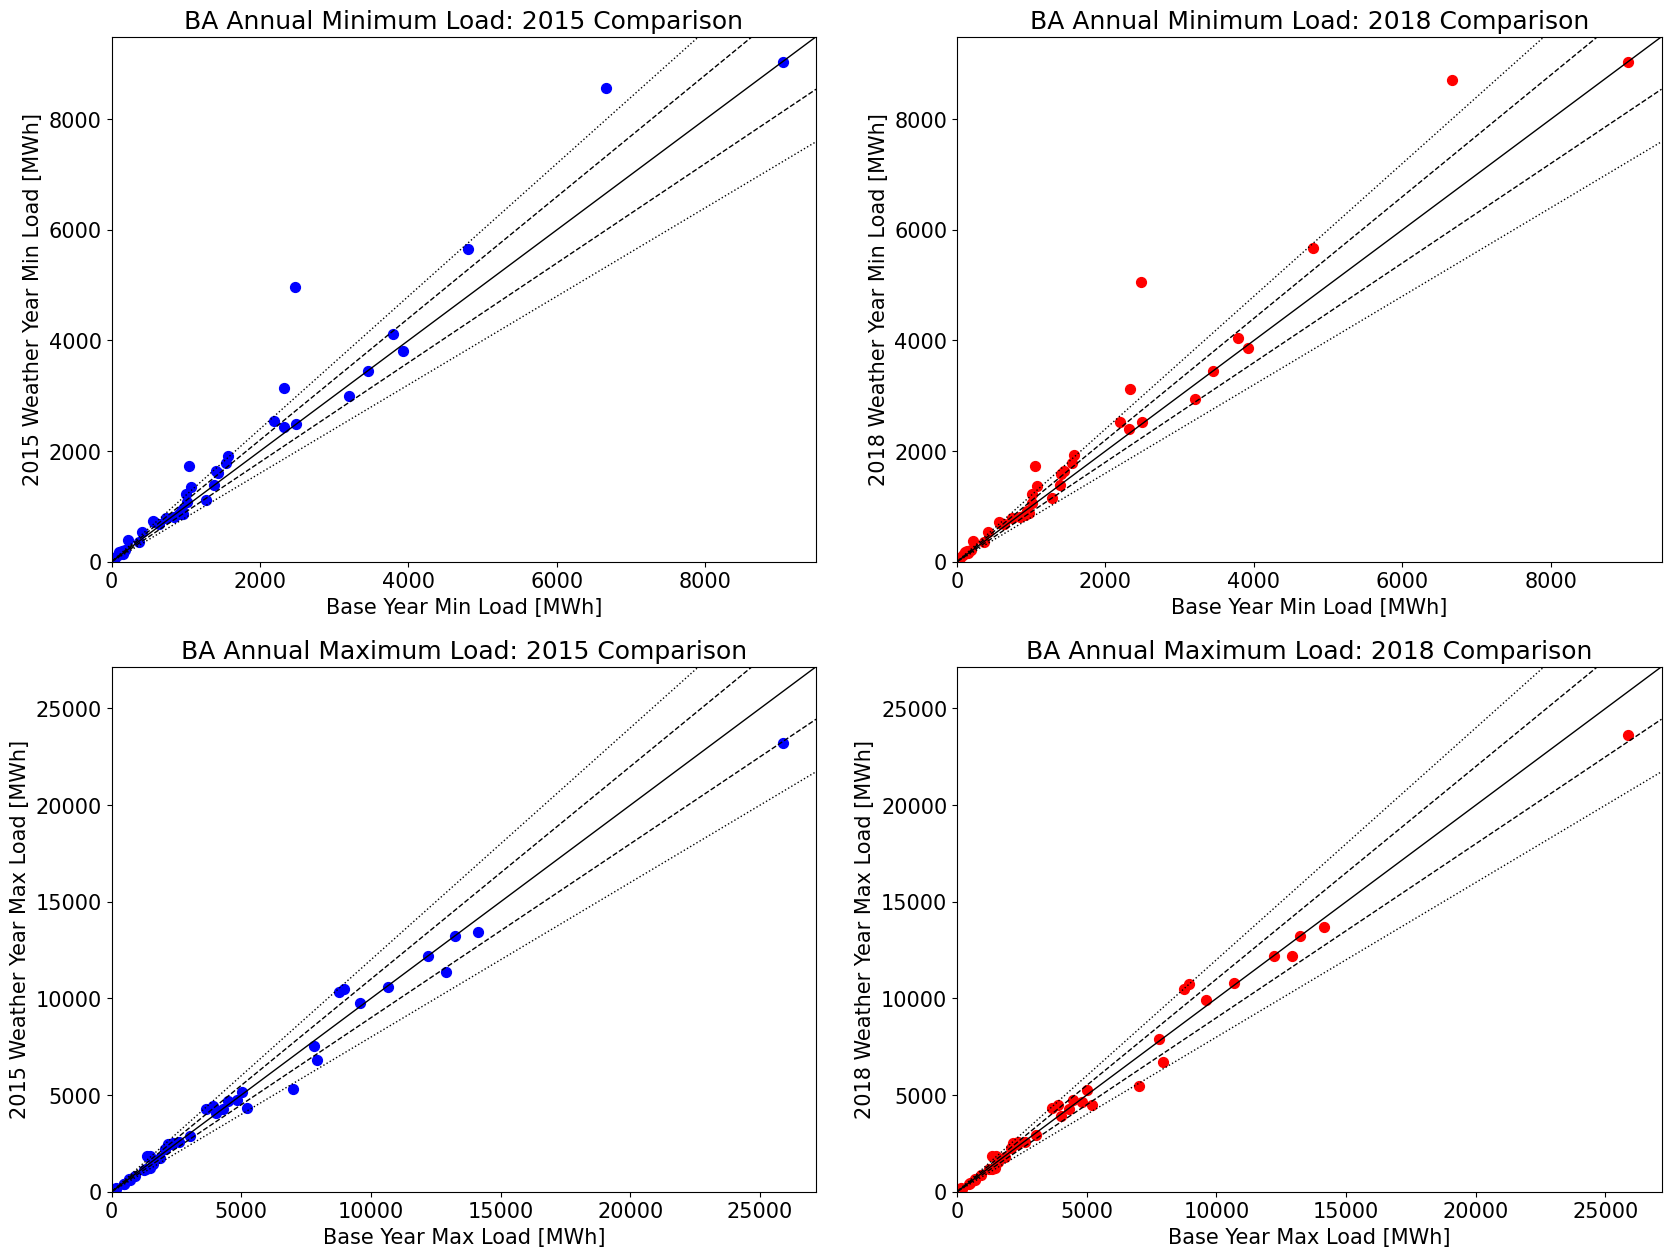

In [49]:
a = create_delta_plots(data_dir = data_dir,
                       image_output_dir = plot_dir, 
                       image_resolution = 300, 
                       save_images = True)

a
